In [1065]:
import warnings 
import numpy as np
import pandas as pd
import seaborn as sea 
import matplotlib.pyplot as plt

In [1066]:
warnings.filterwarnings('ignore',category=pd.errors.SettingWithCopyWarning)

In [1067]:
train = pd.read_csv(r'datasets/TitanicPrediction/train.csv')
test  = pd.read_csv(r'datasets/TitanicPrediction/test.csv')
survived = pd.read_csv(r'datasets/TitanicPrediction/gender_submission.csv')

test = test.merge(right=survived,how='inner',on='PassengerId')
indexTrain , indexTest = train['PassengerId'],test['PassengerId']
dataset = pd.concat([train,test])

In [1068]:
dataset.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [1069]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.377387,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.484918,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


1. Removendo coluna que não será usada para predição `Name` 
    * PassengerId não será removido agora

In [1070]:
dataset.drop(columns=['Name'],inplace=True)

2. Verificando valores `NAN` || `NULL`

In [1071]:
dataset.isna().nunique().reset_index().set_index('index').T

index,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,1,1,2,1,1,1,2,2,2


In [1072]:
dataset.isnull().nunique().reset_index().set_index('index').T

index,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,1,1,2,1,1,1,2,2,2


> Atributos `Fare` , `Cabin` , `Embarked` , `Age` possuem valores nulos será imputado valores neles

2. Vendo valores unicos

In [1073]:
dataset.nunique().reset_index().set_index('index').T

index,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1309,2,3,2,98,7,8,929,281,186,3


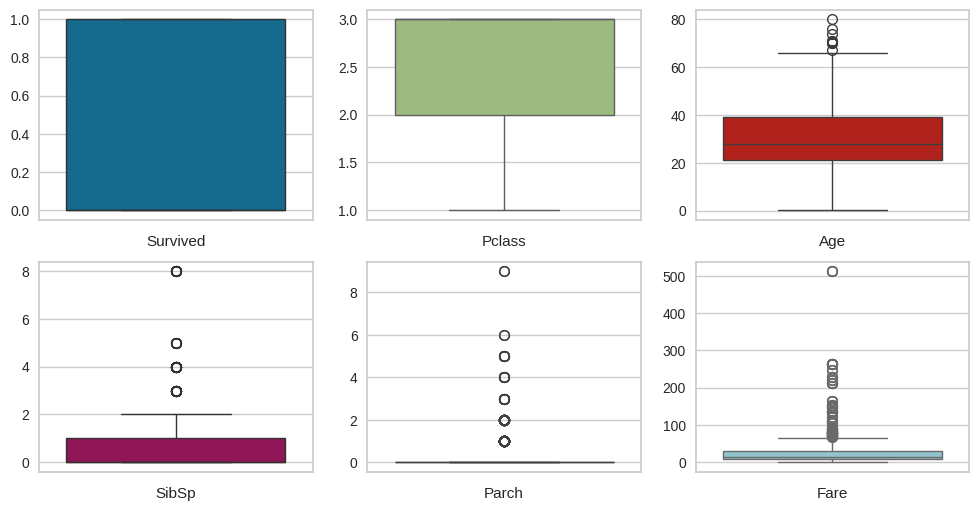

In [1074]:
columns  = dataset.select_dtypes(exclude=['object']).columns[1:]
fig , ax = plt.subplots(2,3)
colors   = sea.color_palette(n_colors=7)
fig.set_figwidth(12)
fig.set_figheight(6)
for column,axis,color in zip(columns,ax.flatten(),colors):
    sea.boxplot(dataset[column],color=color,ax=axis)
    axis.set_ylabel('')
    axis.set_xlabel(column)
plt.show()

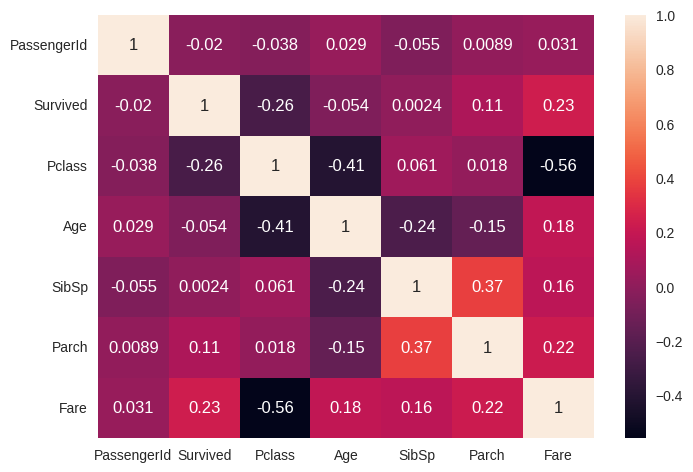

In [1075]:
sea.heatmap(dataset.select_dtypes(exclude='object').corr(),annot=True)
plt.show()

In [1076]:
from scipy.stats import chi2_contingency
for nominal in dataset.select_dtypes(exclude=['int','float']):
    print("-----",nominal.upper())
    for ordinal in dataset.columns[1:]:
        dados = pd.crosstab(dataset[nominal],dataset[ordinal])
        chi2, p, _, _ = chi2_contingency(dados)
        if (p>0.1):
            print(ordinal,"P.:", p)

----- SEX
Age P.: 0.2879255489404147
Ticket P.: 0.954278361832896
Cabin P.: 0.6110075048960104
----- TICKET
Sex P.: 0.954278361832896
Age P.: 0.9999999993171654
Parch P.: 1.0
----- CABIN
Survived P.: 0.24858856387328646
Sex P.: 0.6110075048960104
Age P.: 0.5900056813248535
Parch P.: 0.9402238728568155
----- EMBARKED


&nbsp;

In [1107]:
from sklearn.ensemble        import VotingClassifier,RandomForestClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.linear_model    import LinearRegression,LogisticRegression,SGDClassifier
from sklearn.svm             import SVC
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV    ,
    cross_val_score ,
    KFold
)
from sklearn.pipeline        import Pipeline,clone
from sklearn.base            import BaseEstimator,TransformerMixin
from sklearn.preprocessing   import LabelBinarizer,LabelEncoder,StandardScaler
from sklearn.metrics         import *

In [1078]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute       import IterativeImputer,SimpleImputer

In [1113]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

## Preprocessamento

In [1080]:
data = dataset.copy()

### Dummies

In [1081]:
class Dummies(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):
        return pd.get_dummies(X,columns=self.columns,dtype=int)

### Removendo

In [1082]:
class RemovendoAtributos(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list) -> None:
        self.columns = columns

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return X.drop(columns=self.columns,axis=0)

### transformacao de atributos

In [1083]:
class TransformandoAtributos(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list|str,type=LabelBinarizer()):
        self.columns = columns
        self.type    = type

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        if (type(self.columns) == list):
            X[self.columns] = self.type.fit_transform(X[self.columns])
        else:
            X[self.columns] = self.type.fit_transform(X[self.columns].values)
        return X  

### Imputando

In [1084]:
class Imputer(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list|str,type=None):
        self.columns = columns
        self.type    = type

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        if (self.type=='mode'):     
            X.loc[X[self.columns].isna()][self.columns] = X[self.columns].mode() 
            return X
        if (type(self.columns) == list):
            X[self.columns] = IterativeImputer(estimator=LinearRegression()).fit_transform(X[self.columns])
        else:
            X[self.columns] = IterativeImputer(estimator=LinearRegression()).fit_transform(X[self.columns].values)
        return X  

In [1085]:
transform = Pipeline(
    steps=[
        ('binarizer'        ,TransformandoAtributos('Sex')),
        ('encoder'          ,TransformandoAtributos('Ticket',LabelEncoder())),
        ('imputer1-Fare'    ,Imputer(['Pclass','Sex','SibSp','Parch','Ticket','Fare'])),
        ('imputer2-Age'     ,Imputer(['Fare','Sex','Ticket','Age'])),
        ('imputer3-embarked',Imputer('Embarked','mode')),
        ('encoder -embarked',Dummies(['Parch','SibSp','Embarked','Pclass'])),
        ('padronizacao'     ,Padronizacao(['Age','Fare'])),
        ('drop'             ,RemovendoAtributos(['Cabin','Ticket']))
    ]
)
data = transform.fit_transform(data)

### Padronização

In [1086]:
class Padronizacao(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns 

    def fit(self,X,y=None):
        return self
    
    def transform(self, X:pd.DataFrame):  
        if ( type(self.columns) == list ):
            X[self.columns]   = StandardScaler().fit_transform(X[self.columns])
        else:
            X[[self.columns]] = StandardScaler().fit_transform(X[[self.columns]])
        return X

### definindo conjunto de test e train

In [1087]:
train = data[data['PassengerId'].isin(indexTrain)]
test  = data[data['PassengerId'].isin(indexTest)] 
xtrain, xtest, ytrain, ytest = (
    train.iloc[:,2:],
    test.iloc[:,2:],
    train.iloc[:,2],
    test.iloc[:,2]
)

&nbsp;

### Logistic Regression

In [1109]:
params  = dict(
    solver   = ['saga'],
    l1_ratio = np.linspace(0.1,0.9,9)
    )
gridLog = GridSearchCV(LogisticRegression(penalty='elasticnet',max_iter=600),param_grid=params,scoring='accuracy')
gridLog.fit(xtrain,ytrain)

print('Estimador: ',gridLog.best_estimator_)
print('Acuracia : ',gridLog.best_score_)

Estimador:  LogisticRegression(l1_ratio=0.1, max_iter=600, penalty='elasticnet',
                   solver='saga')
Acuracia :  1.0


In [1110]:
logistic = LogisticRegression(l1_ratio=0.1, max_iter=600, penalty='elasticnet',solver='saga')
logistic.fit(xtrain,ytrain)

LogisticRegression(l1_ratio=0.1, max_iter=600, penalty='elasticnet',
                   solver='saga')

In [1111]:
predLog =logistic.predict(xtest)

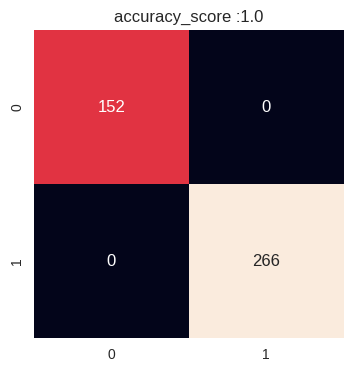

In [1112]:
plt.figure(figsize=(4,4))
sea.heatmap( confusion_matrix(ytest,predLog), annot=True ,cbar=False,fmt='')
plt.title(f'accuracy_score :{accuracy_score(ytest,predLog)}')
plt.show()

In [1119]:
kfold = KFold(n_splits=5)

for i,(traink,testk) in enumerate(kfold.split(data.iloc[:,2:],data.iloc[:,2])):
    xtraink , xtestk = data.iloc[:,2:].iloc[traink] , data.iloc[:,2:].iloc[testk]
    ytraink , ytestk = data.iloc[:,2].iloc[traink], data.iloc[:,2].iloc[testk]

    predk = clone(logistic).fit(xtraink,ytraink).predict(xtestk)
    print('_'*30)
    print(f'fold {i+1} | accuracy_score :{accuracy_score(ytestk,predk)}')
    print(f'recall {recall_score(ytestk,predk)} |',f'f1_score {f1_score(ytestk,predk)}')

______________________________
fold 1 | accuracy_score :1.0
recall 1.0 | f1_score 1.0
______________________________
fold 2 | accuracy_score :1.0
recall 1.0 | f1_score 1.0
______________________________
fold 3 | accuracy_score :1.0
recall 1.0 | f1_score 1.0
______________________________
fold 4 | accuracy_score :1.0
recall 1.0 | f1_score 1.0
______________________________
fold 5 | accuracy_score :1.0
recall 1.0 | f1_score 1.0


&nbsp;

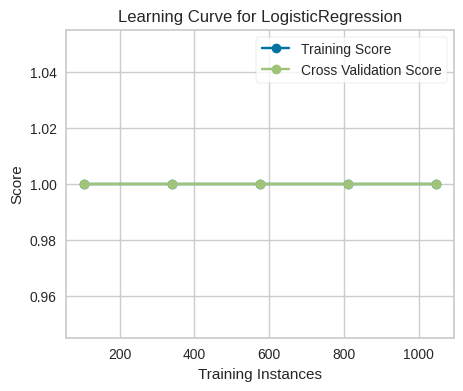

In [1114]:
plt.figure(figsize=(5,4))
learn = LearningCurve(logistic,scoring='accuracy')
learn.fit(data.iloc[:,2:],data.iloc[:,2])
learn.show()
plt.show()

&nbsp;